# Option pricing for bioMérieux : an SBF 120 French biotech company

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### The choice of T and r
#### The T is one year, the maturity is at the 1/03/2024

In [9]:
prices = pd.read_excel('Price.xlsx')
M_TRESO =  pd.read_excel('interest.xlsx')

prices['Date'] = pd.to_datetime(prices['Date'], format = '%Y-%m-%d')
M_TRESO['Date'] = pd.to_datetime(M_TRESO['Date'], format = '%m/%Y')
M_TRESO['France']  = M_TRESO['France'].replace('-',np.nan)
M_TRESO = M_TRESO.sort_values(by = 'Date')
M_TRESO['France'] = M_TRESO['France'].ffill()

#Interpolate the yearly 3M gov yield to daily
M_TRESO.set_index('Date', inplace=True)
daily_M_TRESO = M_TRESO.resample('D').mean()
daily_M_TRESO.interpolate(method='linear', inplace=True)

prices = prices.sort_values(by = 'Date')
prices_int = prices.merge( daily_M_TRESO, on = 'Date', how='left' )

In [10]:
main_df = prices_int[['Date','Price','France']].dropna().rename(columns={"France":'STR'})
main_df['STR'] = main_df['STR'].div(100)

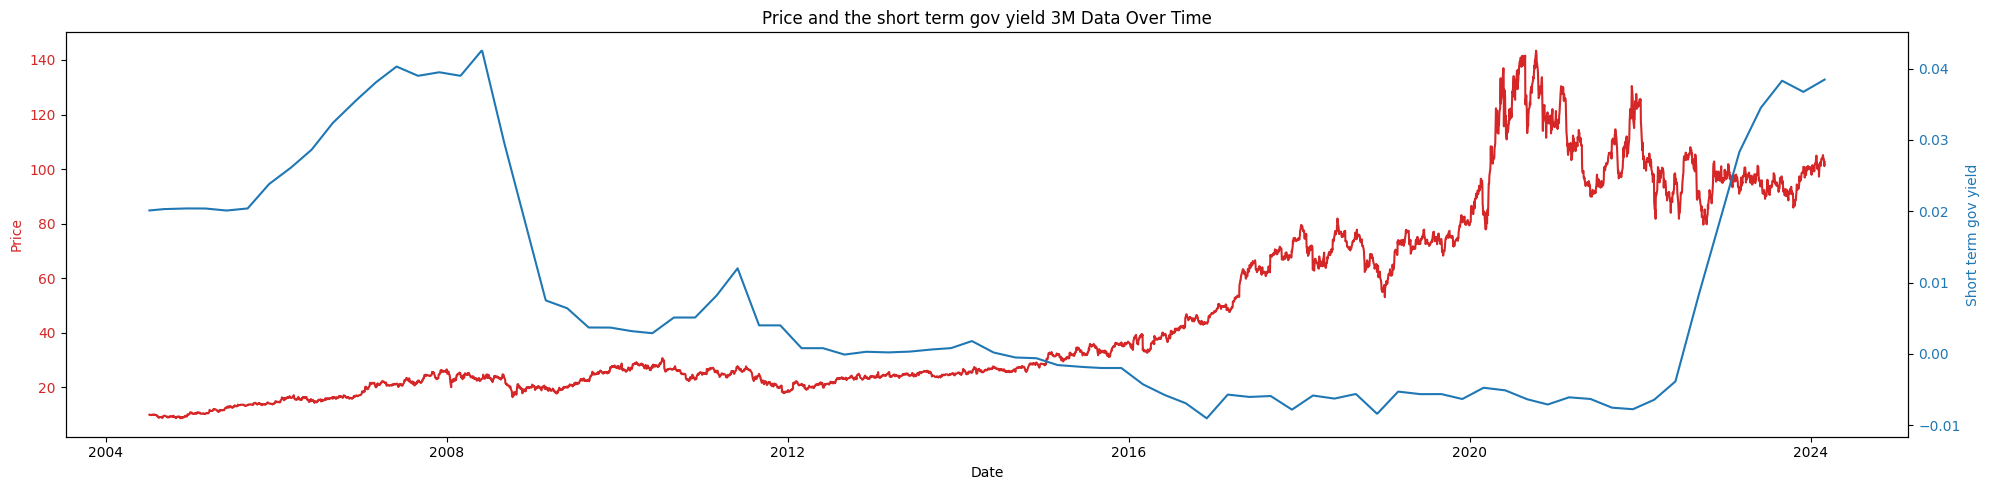

In [11]:
fig, ax1 = plt.subplots(figsize=(20, 5))
# Plotting 'Price' on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color=color)
ax1.plot(main_df.Date, main_df['Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for the 'France' data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Short term gov yield', color=color)  # we already handled the x-label with ax1
ax2.plot(main_df.Date, main_df['STR'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show
plt.title('Price and the short term gov yield 3M Data Over Time')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


We calculate 3 volatilities over differnent periods and then we annuliaze them and choose the one with the highest volatility during drawdowns.

> Ajouter une citation



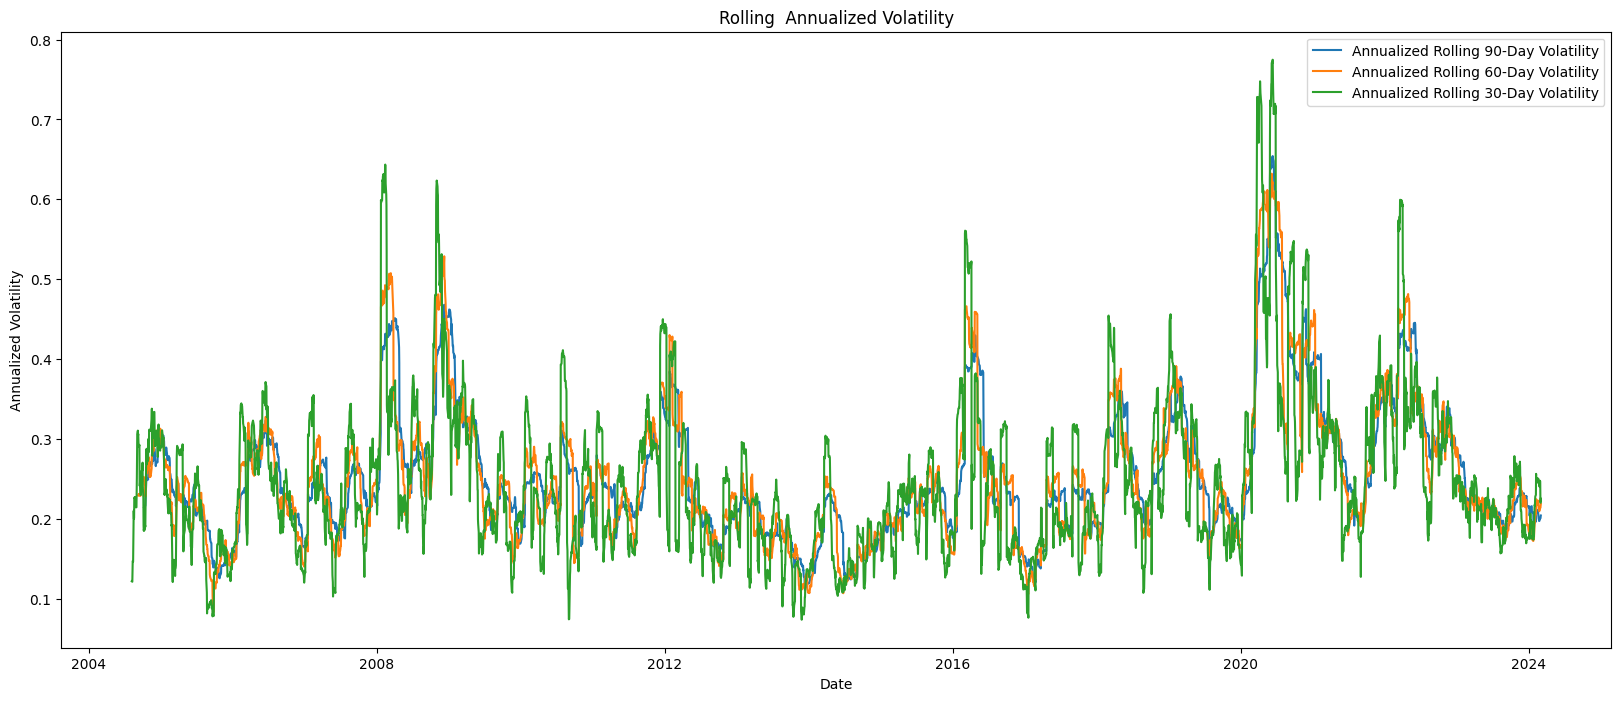

In [12]:
main_df['Daily Returns'] = main_df['Price'].pct_change()
# Calculate rolling 30-day standard deviation of daily returns and annualize it
main_df['Rolling_Volatility3M'] = main_df['Daily Returns'].rolling(window=66).std() * np.sqrt(252)
main_df['Rolling_Volatility2M'] = main_df['Daily Returns'].rolling(window=44).std() * np.sqrt(252)
main_df['Rolling_Volatility1M'] = main_df['Daily Returns'].rolling(window=22).std() * np.sqrt(252)

# Plotting
plt.figure(figsize=(20, 8))
plt.plot(main_df.Date, main_df['Rolling_Volatility3M'], label='Annualized Rolling 90-Day Volatility')
plt.plot(main_df.Date, main_df['Rolling_Volatility2M'], label='Annualized Rolling 60-Day Volatility')
plt.plot(main_df.Date, main_df['Rolling_Volatility1M'], label='Annualized Rolling 30-Day Volatility')

plt.title('Rolling  Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.show()


We can see that the rolling 3 months volatility has higher peaks and troughs.

In [13]:
import numpy as np
from scipy.stats import norm

def black_scholes_div(S, K, T, r, sigma, q, option_type='call'):
    """
    Calculate the Black-Scholes option price for a call or put option with dividend yield.

    Parameters:
    S (float): Stock price
    K (float): Strike price
    T (float): Time to expiration in years
    r (float): Risk-free rate (annual)
    sigma (float): Volatility of the stock's returns (annual)
    q (float): Dividend yield (annual)
    option_type (str): 'call' for call option, 'put' for put option

    Returns:
    float: Black-Scholes option price
    """
    # Calculate d1 and d2 parameters
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        call_price = (S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
        return call_price
    else:
        put_price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1))
        return put_price
import numpy as np
from scipy.stats import norm

def monte_carlo_option_pricing(S, K, T, r, sigma, q, option_type='call', num_simulations=10000):
    """
    Monte Carlo simulation for European option pricing using Geometric Brownian Motion (GBM).

    Parameters:
    S (float): Initial stock price
    K (float): Strike price
    T (float): Time to maturity (in years)
    r (float): Risk-free interest rate
    sigma (float): Volatility of returns
    q (float): Dividend yield
    option_type (str): Type of option ('call' or 'put')
    num_simulations (int): Number of simulations

    Returns:
    float: Estimated option price
    """
    # Time increment
    dt = 1/252  # Daily steps

    # Simulating num_simulations paths
    Z = np.random.normal(0, 1, num_simulations)
    ST = S * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)  # Terminal stock prices

    # Calculate payoffs for call and put options
    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0)  # Call payoff
    else:
        payoffs = np.maximum(K - ST, 0)  # Put payoff

    # Discount payoffs back to present value and average
    option_price = np.exp(-r * T) * np.mean(payoffs)

    return option_price
from scipy.stats import norm

import numpy as np
from scipy.stats import norm

def calculate_greeks(row, option_type='call'):
    S = row['Price']
    K = 110
    T = row['T']   # Convert days to years if T is in days
    r = row['STR']# Example static risk-free rate, adjust as needed
    sigma = row['Rolling_Volatility3M']  # You can choose which volatility measure to use
    q = row['q']  # Dividend yield

    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate Greeks based on option type
    if option_type == 'call':
        delta = np.exp(-q * T) * norm.cdf(d1)
        price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        delta = -np.exp(-q * T) * norm.cdf(-d1)
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

    gamma = np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = (-S * sigma * np.exp(-q * T) * norm.pdf(d1) / (2 * np.sqrt(T))
             - r * K * np.exp(-r * T) * norm.cdf(d2 if option_type=='call' else -d2)
             + q * S * np.exp(-q * T) * norm.cdf(d1 if option_type=='call' else -d1))
    vega = S * np.sqrt(T) * np.exp(-q * T) * norm.pdf(d1) * 0.01  # per 1% change in volatility
    rho = K * T * np.exp(-r * T) * norm.cdf(d2 if option_type=='call' else -d2) * 0.01  # per 1% change in interest rate

    return pd.Series({'Price': price, 'Delta': delta, 'Gamma': gamma, 'Theta': theta, 'Vega': vega, 'Rho': rho})


import numpy as np
from scipy.stats import norm

import numpy as np
from scipy.stats import norm
import pandas as pd

def calculate_original_greeks(row):
    S = row['Price']
    K = 110
    T = row['T']   # Assuming T is given in days, convert to years
    r = row['STR']  # Static risk-free rate, adjust as necessary
    sigma = row['Rolling_Volatility3M']
    q = row['q']

    # Black-Scholes calculations
    return black_scholes_greeks(S, K, T, r, sigma, q)

def calculate_adjusted_greeks(row):
    S = row['Price']
    K =  110
    T = row['T']
    r = row['STR'] * (1 - (0.019 + np.random.uniform(-0.005, 0.005)))
    sigma = row['Rolling_Volatility3M'] * (1 + (0.034 + np.random.uniform(-0.005, 0.005)))  # 3.4% increase varied by ±0.5%
    q = row['q']

    # Black-Scholes calculations
    return black_scholes_greeks(S, K, T, r, sigma, q)

def black_scholes_greeks(S, K, T, r, sigma, q):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return {
        'Delta': np.exp(-q * T) * norm.cdf(d1),
        'Gamma': np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T)),
        'Theta': -S * sigma * np.exp(-q * T) * norm.pdf(d1) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2) + q * S * np.exp(-q * T) * norm.cdf(d1),
        'Vega': S * np.sqrt(T) * np.exp(-q * T) * norm.pdf(d1) * 0.01,  # scaled for 1% change
        'Rho': K * T * np.exp(-r * T) * norm.cdf(d2) * 0.01  # scaled for 1% change
    }





# Price a call using Black and scholes (t-255), t= 01/03/2023


1.   Strike 110
2.   Maturity 01/03/2024
3.   Volatility = 3 months rolling
4.   interest rate = the 3M gov yield
5.   Divdend = 0.85 EURO






In [14]:
#price a call at 01/03/2023 maturity 01/03/2024
#See how the price evolves across time up to maturity


In [21]:
main_df['q'] = 0.85/main_df['Price']
maturity_date = '2024-02-29'
maturity_date = pd.to_datetime(maturity_date)
main_df['DTE'] = (maturity_date - main_df['Date']).dt.days
main_df['DTE'] = main_df['DTE'].apply(lambda x: x if x >= 0 else 0)
main_df['T'] = main_df['DTE'] / 365


In [25]:
bs_df = main_df[main_df['Date']>='2023-02-28']

In [26]:
# Constants
VOL_COLUMN = 'Rolling_Volatility3M'  # Example volatility column

# Applying the function to the DataFrame
bs_df['BS_CALL'] = bs_df.apply(lambda row: black_scholes_div(
    S=row['Price'],
    K=110,
    T=row['T'],  # Assuming 'T' is in days and needs to be converted to years
    r=row['STR'],
    sigma=row[VOL_COLUMN],
    q=row['q'],
    option_type='call'
), axis=1)


<ipython-input-13-f3d6c99e6def>:21: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-26-f00c03a25a25>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df['BS_CALL'] = bs_df.apply(lambda row: black_scholes_div(


## Price a call using the black and scholes model
The Black-Scholes model, created by Fischer Black, Myron Scholes, and Robert Merton in 1973, is a seminal framework for pricing European options, which are financial derivatives that can only be exercised at their expiration. This model revolutionized financial markets by providing a mathematical formula to estimate the price of options based on several assumptions. These include no dividends paid by the underlying stock, an efficient and arbitrage-free market, a known and constant risk-free interest rate, and continuous trading opportunities. The model presumes that stock prices follow a log-normal distribution, reflecting that the stock prices are continuous and their volatility is constant over time, an assumption that simplifies calculations but can deviate from real market behaviors.

Despite its foundational status in financial engineering, the Black-Scholes model has limitations due to its idealized assumptions. Real-world anomalies such as variable volatility (contradicting the model's constant volatility assumption) and the occurrence of significant market jumps or crashes are not accounted for in the model. This often results in the "volatility smile," where implied volatility is higher for deep in-the-money or out-of-the-money options, a pattern not predicted by the model. Moreover, the assumption of no dividends and constant interest rates can further skew the accuracy when applied to longer-term options or stocks that pay dividends. Nonetheless, the Black-Scholes model continues to be a fundamental tool in finance, used widely with modifications and extensions to better align with market realities.

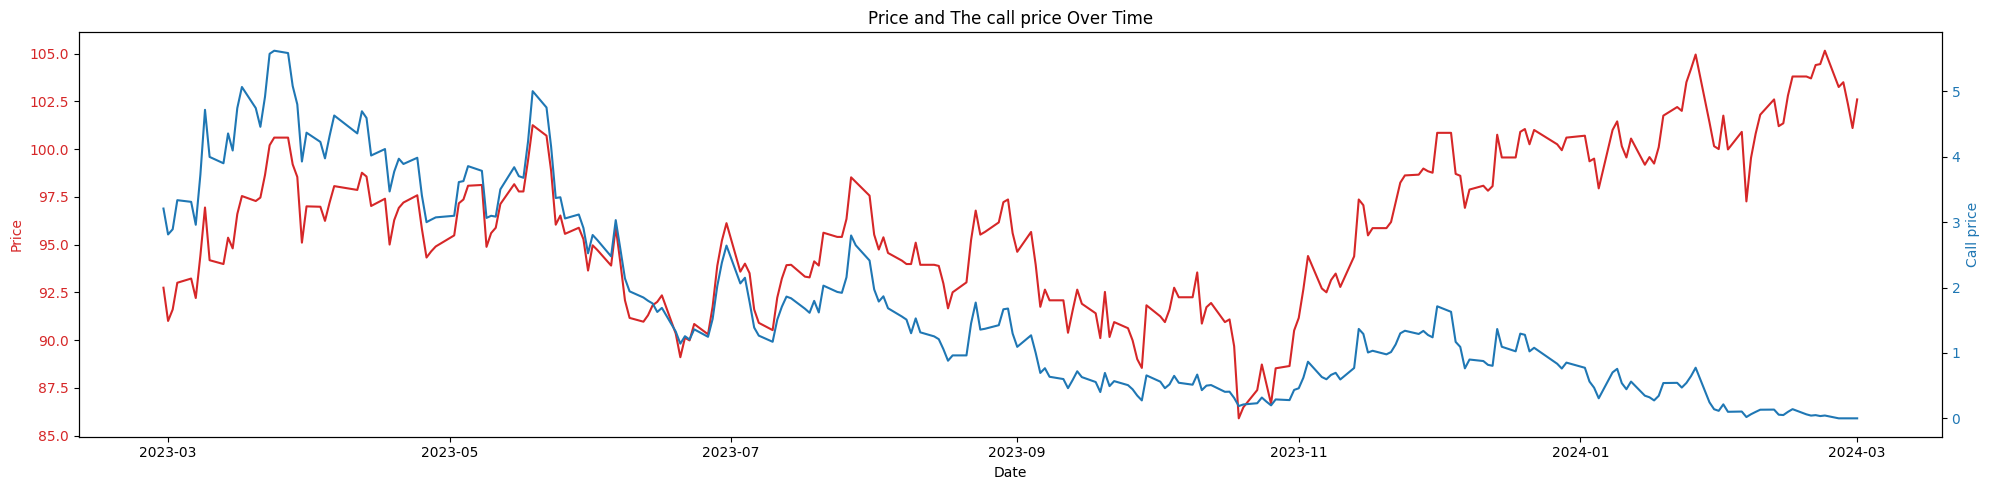

In [27]:
fig, ax1 = plt.subplots(figsize=(20, 5))
# Plotting 'Price' on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color=color)
ax1.plot(bs_df.Date, bs_df['Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for the 'France' data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Call price', color=color)  # we already handled the x-label with ax1
ax2.plot(bs_df.Date, bs_df['BS_CALL'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show
plt.title('Price and The call price Over Time')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [28]:
VOL_COLUMN = 'Rolling_Volatility3M'  # Example volatility column

# Applying the function to the DataFrame
bs_df['BS_PUT'] = bs_df.apply(lambda row: black_scholes_div(
    S=row['Price'],
    K=110,
    T=row['T'],  # Assuming 'T' is in days and needs to be converted to years
    r=row['STR'],
    sigma=row[VOL_COLUMN],
    q=row['q'],
    option_type='put'
), axis=1)


<ipython-input-13-f3d6c99e6def>:21: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-28-19fe5f84f74e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df['BS_PUT'] = bs_df.apply(lambda row: black_scholes_div(


## Price a bioMérieux put with maturity 1 year using the BS


In [ ]:
##

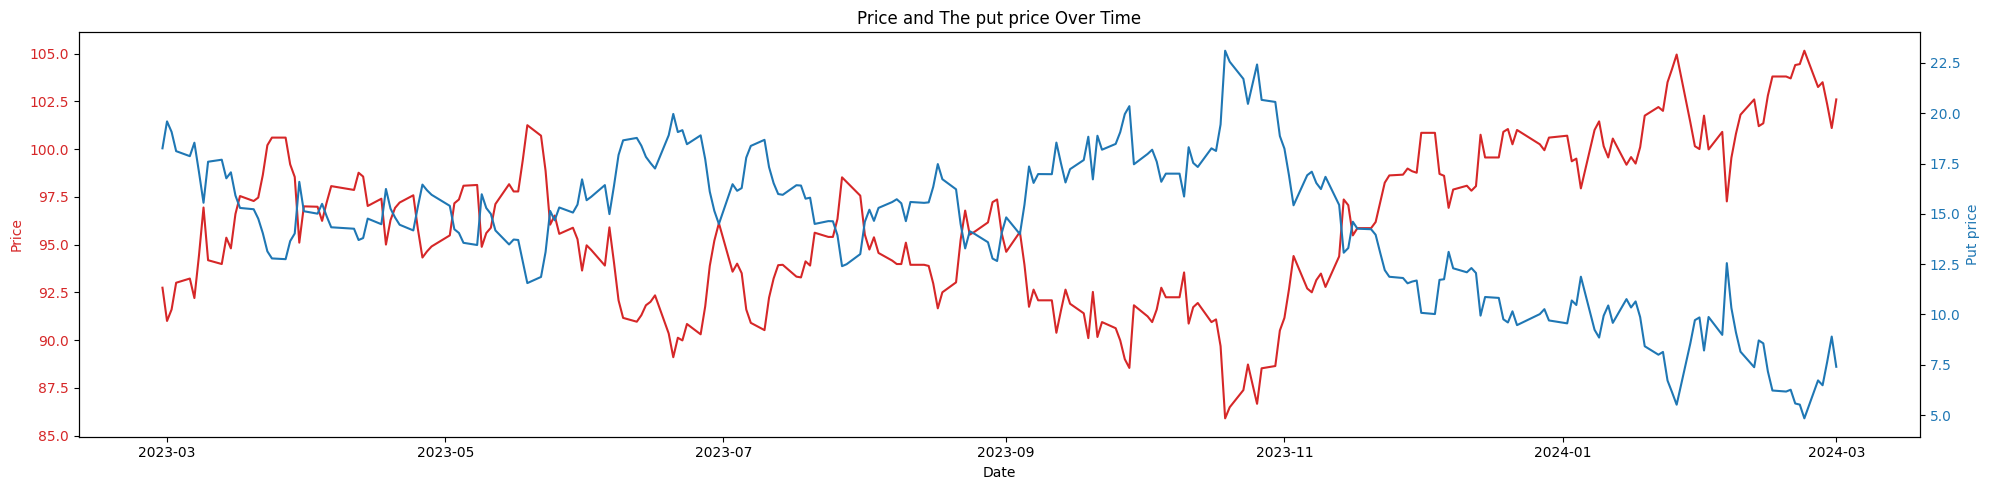

In [29]:
fig, ax1 = plt.subplots(figsize=(20, 5))
# Plotting 'Price' on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color=color)
ax1.plot(bs_df.Date, bs_df['Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for the 'France' data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Put price', color=color)  # we already handled the x-label with ax1
ax2.plot(bs_df.Date, bs_df['BS_PUT'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show
plt.title('Price and The put price Over Time')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [ ]:
#

## Price a call and put using monte carlo

The Monte Carlo method is a statistical technique that employs random sampling to estimate mathematical and physical processes, particularly useful for modeling complex systems and calculating probabilities of different outcomes in uncertain scenarios. This method involves simulating thousands or millions of trials using random variables to mimic the processes under study. In financial applications, Monte Carlo simulations are crucial for the valuation of options and other financial derivatives where the payoff depends on the stochastic paths of underlying asset prices over time. For example, in options pricing, it simulates various future price paths of the underlying asset according to predefined stochastic processes, calculates the payoffs for these paths, and uses the average to estimate the option's fair value.

Geometric Brownian Motion (GBM) is one such stochastic process employed in these simulations to model the logarithmic returns of stock prices as normally distributed, making stock prices themselves log-normally distributed. This model is defined by its drift and volatility components, which represent the expected return and the standard deviation of returns, respectively. The drift signifies the average direction of the stock price (up or down), while the volatility measures the uncertainty or risk associated with the price changes. GBM is widely used in financial modeling to reflect the continuous and random motion observed in stock prices, capturing the realistic dynamics of financial markets where the future price of a stock is uncertain and contingent on a range of influencing factors.

In [30]:
# Constants
VOL_COLUMN = 'Rolling_Volatility3M'  # Choosing appropriate volatility based on your preference
NUM_SIMULATIONS = 7000  # Number of simulations per option

# Calculate call and put prices using Monte Carlo simulation
bs_df['MC_CALL'] = bs_df.apply(lambda row: monte_carlo_option_pricing(
    S=row['Price'],
    K=110,
    T=row['T'] ,  # Convert 'T' from days to years if necessary
    r=row['STR'],
    sigma=row[VOL_COLUMN],
    q=row['q'],
    option_type='call',
    num_simulations=NUM_SIMULATIONS
), axis=1)

bs_df['MC_PUT'] = bs_df.apply(lambda row: monte_carlo_option_pricing(
    S=row['Price'],
    K=110,
    T=row['T'] ,  # Convert 'T' from days to years if necessary
    r=row['STR'],
    sigma=row[VOL_COLUMN],
    q=row['q'],
    option_type='put',
    num_simulations=NUM_SIMULATIONS
), axis=1)


<ipython-input-30-c4b376a3f8b6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df['MC_CALL'] = bs_df.apply(lambda row: monte_carlo_option_pricing(
<ipython-input-30-c4b376a3f8b6>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df['MC_PUT'] = bs_df.apply(lambda row: monte_carlo_option_pricing(


## Graph the monte carlo put and call prices

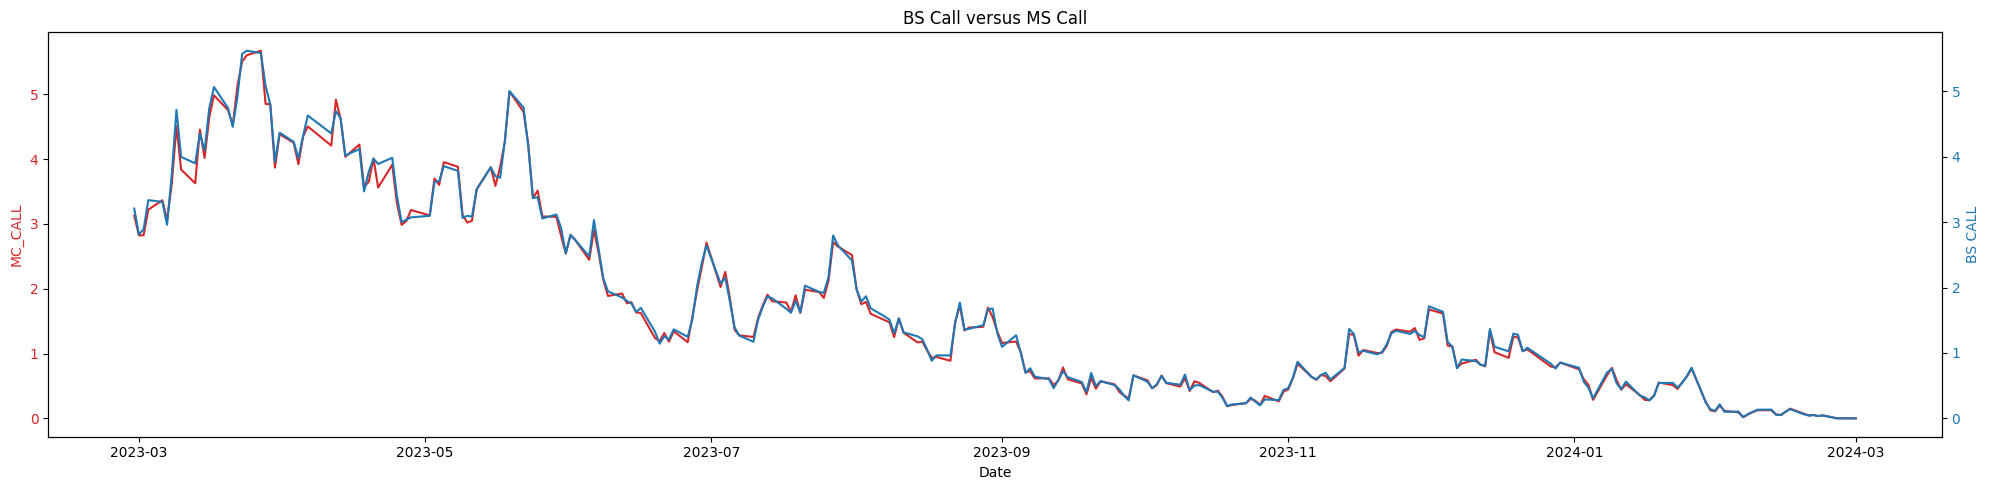

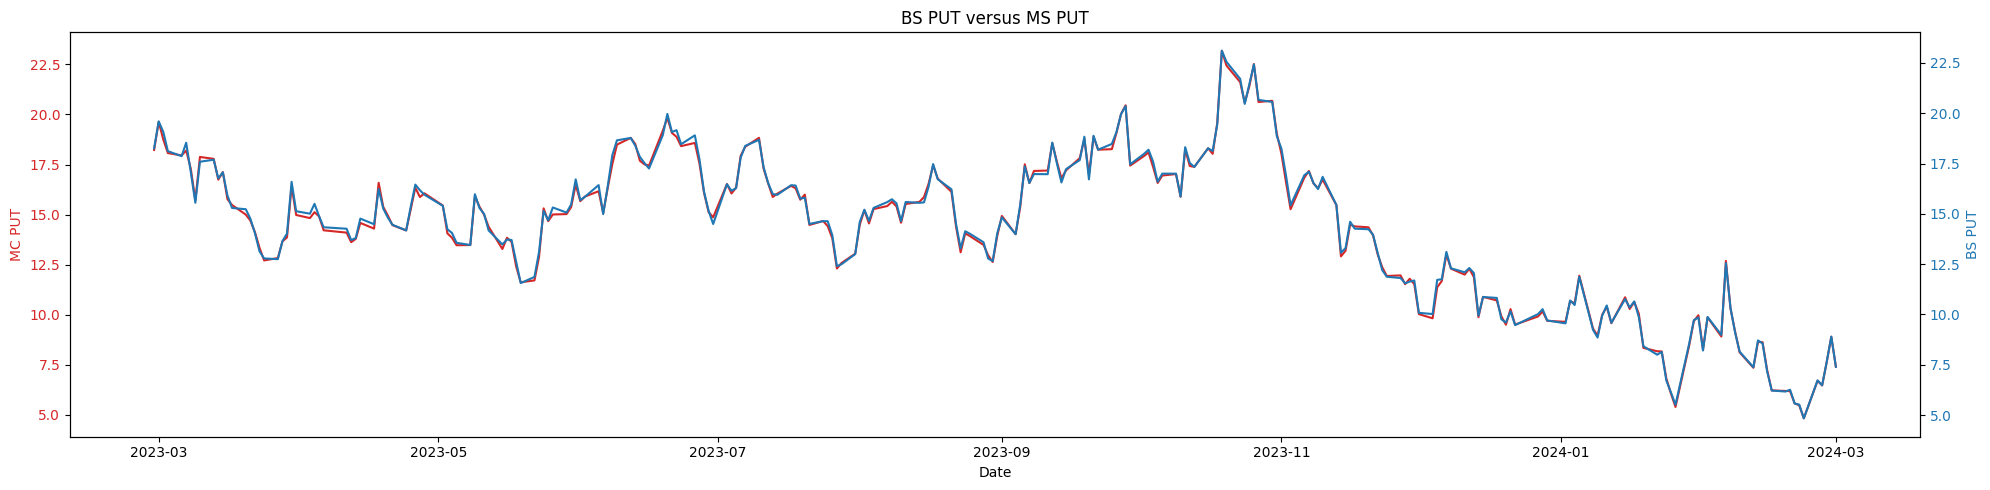

In [31]:
fig, ax1 = plt.subplots(figsize=(20, 5))
# Plotting 'Price' on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('MC_CALL', color=color)
ax1.plot(bs_df.Date, bs_df['MC_CALL'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for the 'France' data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('BS CALL', color=color)  # we already handled the x-label with ax1
ax2.plot(bs_df.Date, bs_df['BS_CALL'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show
plt.title('BS Call versus MS Call')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

fig, ax1 = plt.subplots(figsize=(20, 5))
# Plotting 'Price' on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('MC PUT', color=color)
ax1.plot(bs_df.Date, bs_df['MC_PUT'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for the 'France' data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('BS PUT', color=color)  # we already handled the x-label with ax1
ax2.plot(bs_df.Date, bs_df['BS_PUT'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show
plt.title('BS PUT versus MS PUT')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


## Check the parity condition for both the monte carlo simulation and the black and scholes.

In [32]:
import numpy as np

# Constants

# Calculate the theoretical RHS of the put-call parity (considering dividends)
bs_df['Theoretical_RHS'] = bs_df['Price'] * np.exp(-bs_df['q'] * bs_df['T'] ) - \
                           110 * np.exp(- bs_df['STR'] * bs_df['T'] )
# Calculate the LHS of the put-call parity
bs_df['Calculated_LHS'] = bs_df['MC_CALL'] - bs_df['MC_PUT']

# Check if parity holds (within a small epsilon due to simulation errors)
epsilon = 0.1  # Tolerance for checking equality
bs_df['Parity_Holds'] = np.abs(bs_df['Calculated_LHS'] - bs_df['Theoretical_RHS']) < epsilon

# Display the results
print(bs_df[['MC_CALL', 'MC_PUT', 'Calculated_LHS', 'Theoretical_RHS', 'Parity_Holds']])


       MC_CALL     MC_PUT  Calculated_LHS  Theoretical_RHS  Parity_Holds
9604  3.126035  18.228876      -15.102841       -15.047544          True
9605  2.821949  19.635491      -16.813542       -16.780956          True
9606  2.824477  18.751687      -15.927210       -16.179744         False
9607  3.218411  18.073331      -14.854920       -14.778604          True
9608  3.364179  17.954732      -14.590553       -14.555255          True
...        ...        ...             ...              ...           ...
9857  0.000178   6.706728       -6.706550        -6.722279          True
9858  0.000000   6.469163       -6.469163        -6.481507          True
9859  0.000000   7.641564       -7.641564        -7.640747          True
9860  0.000000   8.900000       -8.900000        -8.900000          True
9861  0.000000   7.400000       -7.400000        -7.400000          True

[258 rows x 5 columns]


<ipython-input-32-d3f1e50bcae3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df['Theoretical_RHS'] = bs_df['Price'] * np.exp(-bs_df['q'] * bs_df['T'] ) - \
<ipython-input-32-d3f1e50bcae3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df['Calculated_LHS'] = bs_df['MC_CALL'] - bs_df['MC_PUT']
<ipython-input-32-d3f1e50bcae3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [33]:
import numpy as np

# Constants

# Calculate the theoretical RHS of the put-call parity (considering dividends)
bs_df['Theoretical_RHS'] = bs_df['Price'] * np.exp(-bs_df['q'] * bs_df['T'] ) - \
                           110 * np.exp(- bs_df['STR'] * bs_df['T'] )
# Calculate the LHS of the put-call parity
bs_df['Calculated_LHS'] = bs_df['BS_CALL'] - bs_df['BS_PUT']

# Check if parity holds (within a small epsilon due to simulation errors)
epsilon = 0.1  # Tolerance for checking equality
bs_df['Parity_Holds'] = np.abs(bs_df['Calculated_LHS'] - bs_df['Theoretical_RHS']) < epsilon

# Display the results
print(bs_df[['BS_CALL', 'BS_PUT', 'Calculated_LHS', 'Theoretical_RHS', 'Parity_Holds']])


           BS_CALL     BS_PUT  Calculated_LHS  Theoretical_RHS  Parity_Holds
9604  3.207580e+00  18.255124      -15.047544       -15.047544          True
9605  2.811759e+00  19.592715      -16.780956       -16.780956          True
9606  2.891104e+00  19.070848      -16.179744       -16.179744          True
9607  3.335793e+00  18.114397      -14.778604       -14.778604          True
9608  3.310181e+00  17.865436      -14.555255       -14.555255          True
...            ...        ...             ...              ...           ...
9857  1.363417e-04   6.722415       -6.722279        -6.722279          True
9858  7.520582e-06   6.481514       -6.481507        -6.481507          True
9859  6.087509e-13   7.640747       -7.640747        -7.640747          True
9860  0.000000e+00   8.900000       -8.900000        -8.900000          True
9861  0.000000e+00   7.400000       -7.400000        -7.400000          True

[258 rows x 5 columns]


<ipython-input-33-8c343904f0f2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df['Theoretical_RHS'] = bs_df['Price'] * np.exp(-bs_df['q'] * bs_df['T'] ) - \
<ipython-input-33-8c343904f0f2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df['Calculated_LHS'] = bs_df['BS_CALL'] - bs_df['BS_PUT']
<ipython-input-33-8c343904f0f2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

## Implied volatility

Implied volatility is a key concept in the pricing of financial derivatives, particularly options. It represents the market's forecast of a likely movement in a security's price and is derived from the market price of a market-traded derivative (in particular options) rather than from the historical pricing data of the security itself. Essentially, implied volatility is an estimation of the underlying asset’s volatility over the life of the option as implied by the option’s market price, given a specific option pricing model, typically the Black-Scholes model.

In [ ]:
#For the pricing of calls and puts using MC and BS, we used the historical realized volatility

# Greeks


In [34]:
# Apply the function for calls and puts
bs_df[['Call_Price', 'Call_Delta', 'Call_Gamma', 'Call_Theta', 'Call_Vega', 'Call_Rho']] = bs_df.apply(lambda row: calculate_greeks(row, 'call'), axis=1)
bs_df[['Put_Price', 'Put_Delta', 'Put_Gamma', 'Put_Theta', 'Put_Vega', 'Put_Rho']] = bs_df.apply(lambda row: calculate_greeks(row, 'put'), axis=1)


<ipython-input-13-f3d6c99e6def>:81: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-13-f3d6c99e6def>:92: RuntimeWarning: invalid value encountered in scalar divide
  gamma = np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))
<ipython-input-13-f3d6c99e6def>:93: RuntimeWarning: invalid value encountered in scalar divide
  theta = (-S * sigma * np.exp(-q * T) * norm.pdf(d1) / (2 * np.sqrt(T))
<ipython-input-34-00da7316c8f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_df[['Call_Price', 'Call_Delta', 'Call_Gamma', 'Call_Theta', 'Call_Vega', 'Call_Rho']] = bs_df.apply(lambda row: calculate_greeks(row, 'call'), axis=1)
<ipython-input-34-

In [35]:
bs_df=bs_df.reset_index()

## Graph the greeks over time

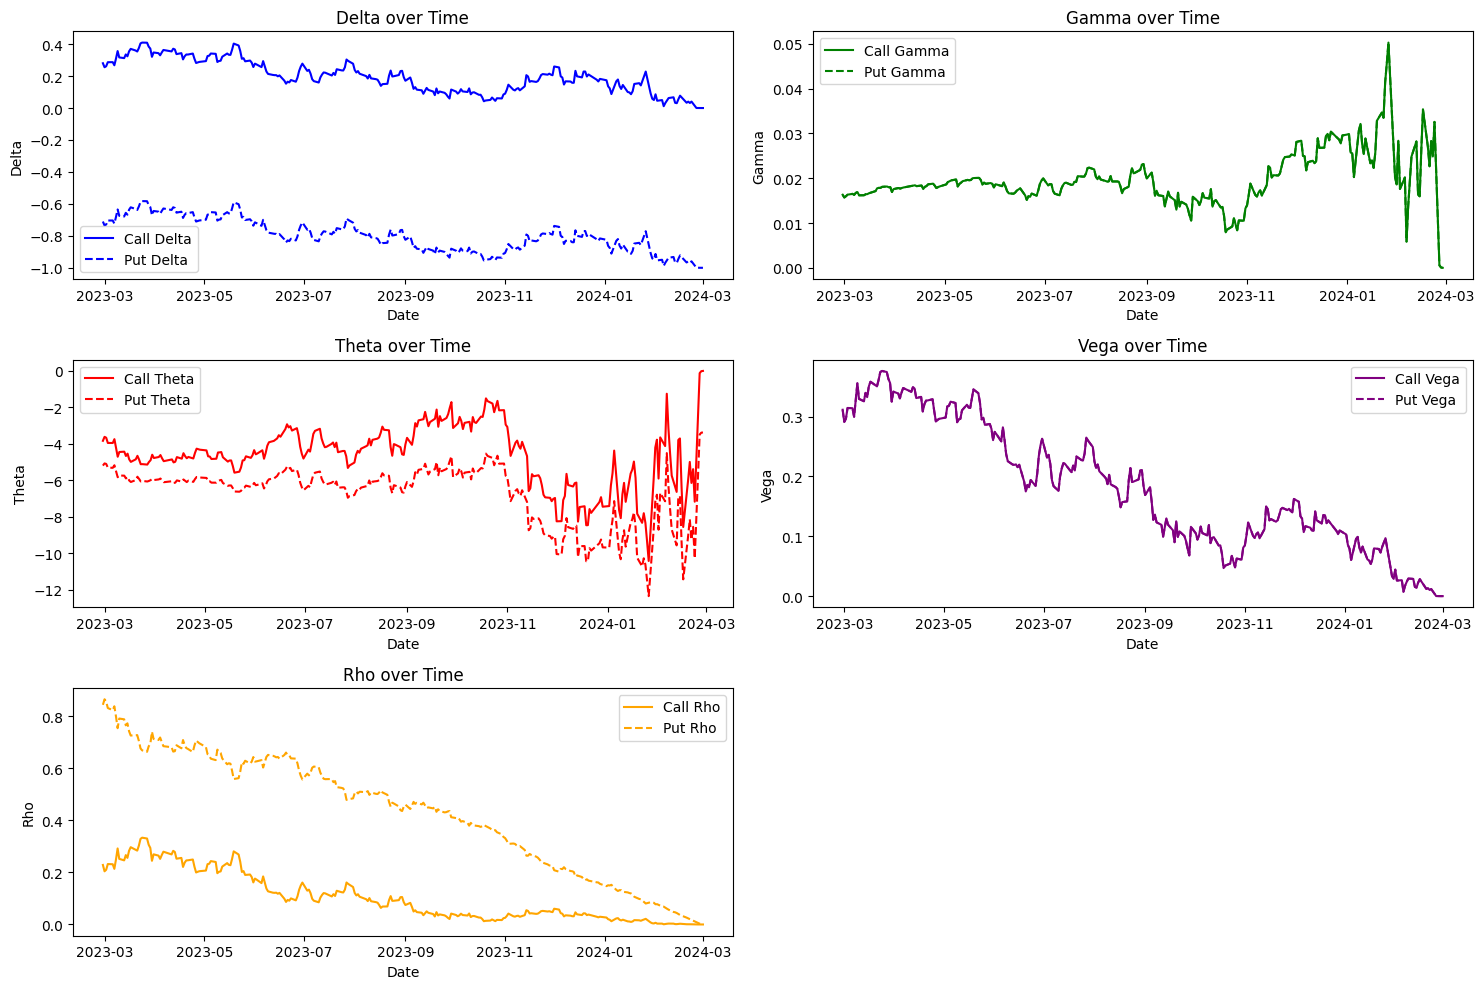

In [36]:
import matplotlib.pyplot as plt

# Setting the plot size
plt.figure(figsize=(15, 10))

greek_types = ['Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
colors = ['blue', 'green', 'red', 'purple', 'orange']

for i, greek in enumerate(greek_types):
    plt.subplot(3, 2, i+1)
    plt.plot(bs_df['Date'], bs_df[f'Call_{greek}'], label=f'Call {greek}', color=colors[i])
    plt.plot(bs_df['Date'], bs_df[f'Put_{greek}'], label=f'Put {greek}', color=colors[i], linestyle='dashed')
    plt.title(f'{greek} over Time')
    plt.xlabel('Date')
    plt.ylabel(greek)
    plt.legend()

plt.tight_layout()
plt.show()


Delta over Time: This plot shows how the option's delta changes. Delta measures the rate of change in the option's price per unit change in the underlying asset's price. Call options have positive delta (0 to 1), while put options have negative delta (0 to -1).

Gamma over Time: Gamma measures the rate of change in delta for a one-unit change in the price of the underlying asset. It is highest when an option is at-the-money and decreases as it moves into or out-of-the-money.

Vega over Time: Vega shows the sensitivity of an option’s price to changes in the volatility of the underlying asset. It indicates the dollar amount change in the option's price for a 1% change in implied volatility.

Theta over Time: Theta represents the rate of change in the option's price as time passes, also known as time decay. For both calls and puts, theta is typically negative, meaning the value of the option decreases as expiration approaches.

Rho over Time: Rho measures the sensitivity of the option’s price to changes in the risk-free interest rate. It is usually more significant for options with longer times to expiration.

## Greek shocks (simulate a shock)

In [37]:
bs_df_co = bs_df.copy()
# Apply the functions
bs_df_co[['Original_Delta', 'Original_Gamma', 'Original_Theta', 'Original_Vega', 'Original_Rho']] = bs_df_co.apply(calculate_original_greeks, axis=1, result_type='expand')
bs_df_co[['Adjusted_Delta', 'Adjusted_Gamma', 'Adjusted_Theta', 'Adjusted_Vega', 'Adjusted_Rho']] = bs_df_co.apply(calculate_adjusted_greeks, axis=1, result_type='expand')


<ipython-input-13-f3d6c99e6def>:132: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-13-f3d6c99e6def>:136: RuntimeWarning: invalid value encountered in scalar divide
  'Gamma': np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T)),
<ipython-input-13-f3d6c99e6def>:137: RuntimeWarning: invalid value encountered in scalar divide
  'Theta': -S * sigma * np.exp(-q * T) * norm.pdf(d1) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2) + q * S * np.exp(-q * T) * norm.cdf(d1),
<ipython-input-13-f3d6c99e6def>:132: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-13-f3d6c99e6def>:136: RuntimeWarning: invalid value encountered in scalar divide
  'Gamma': np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T)),
<ipython-input-13-f3d6c99e6def>:137: RuntimeWarning: invalid value encou

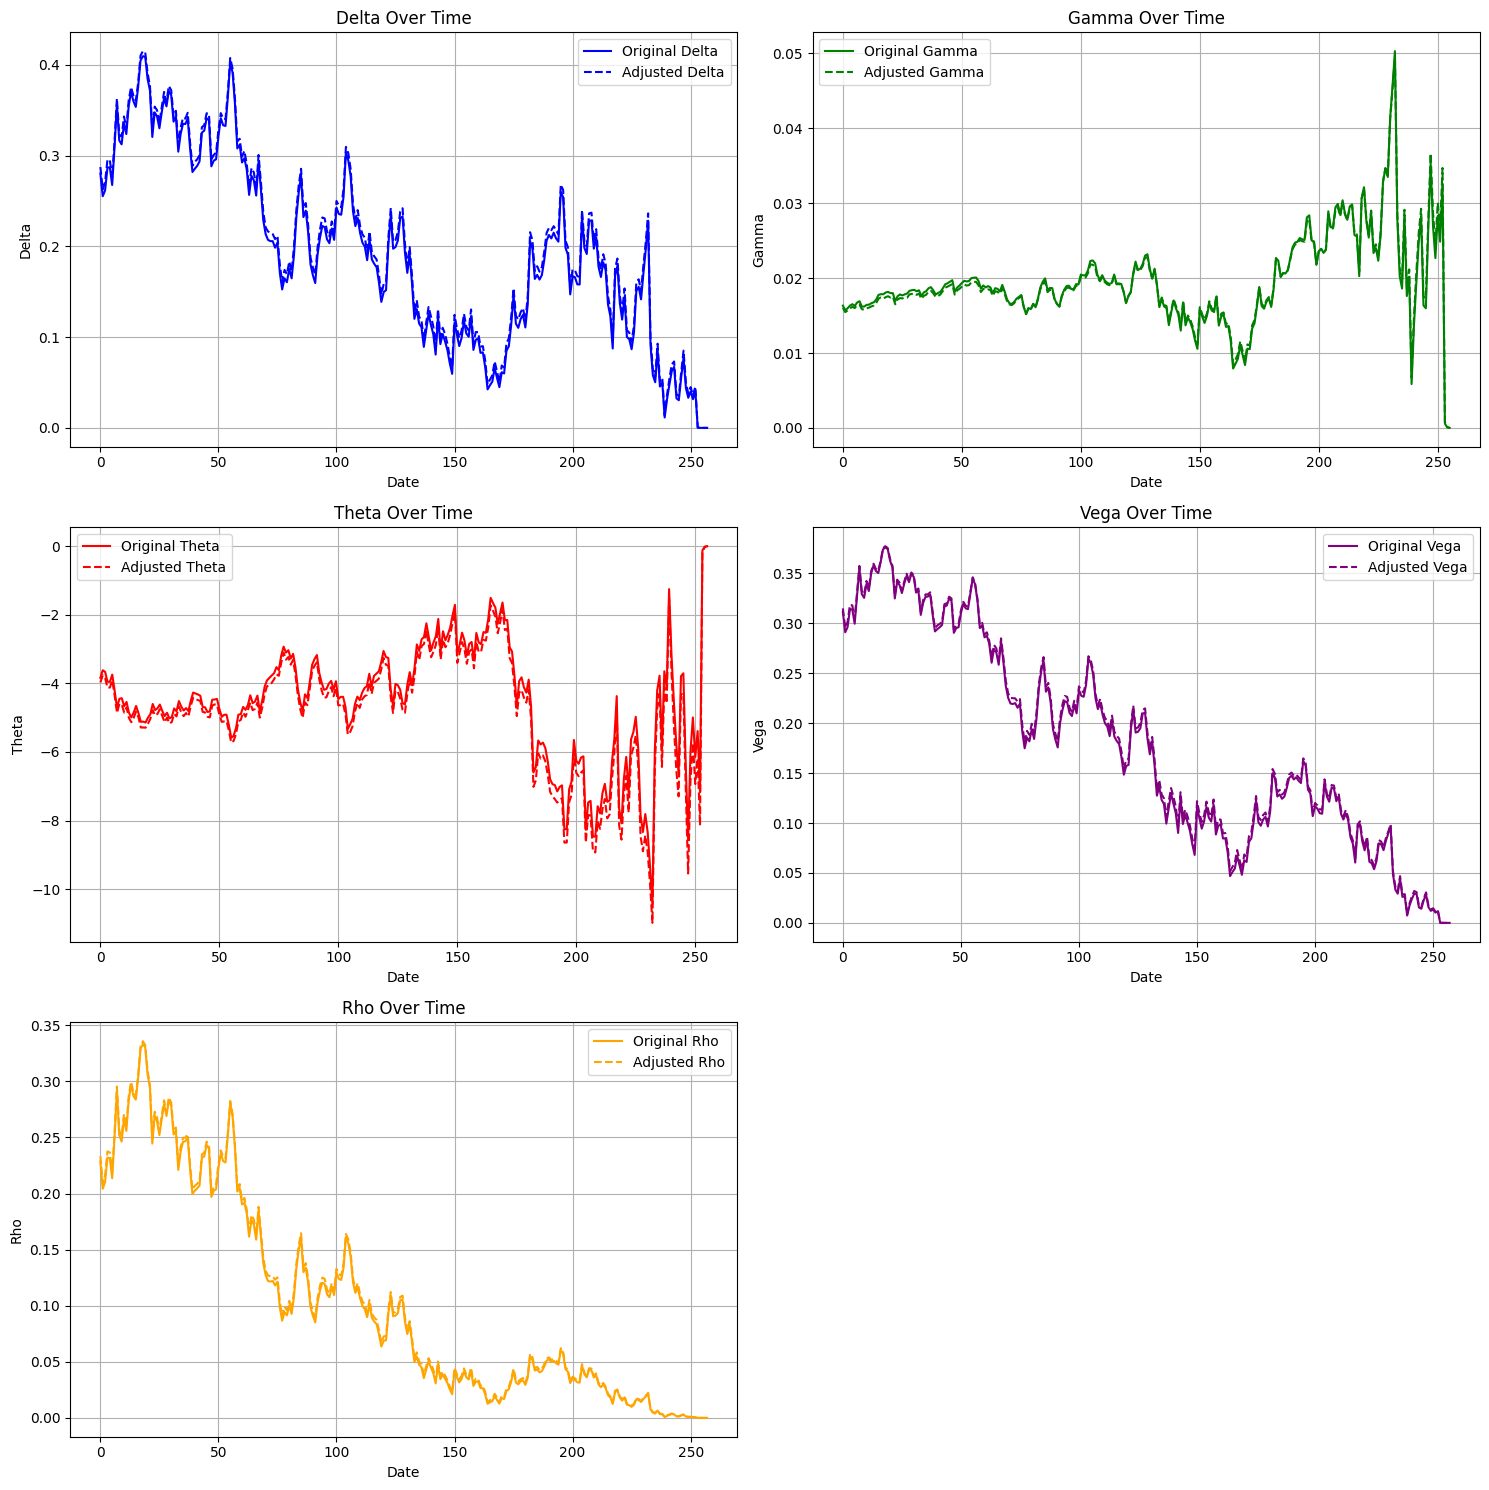

In [40]:
import matplotlib.pyplot as plt

# Ensure 'Date' is the datetime index for easier plotting

plt.figure(figsize=(15, 15))
greek_types = ['Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
colors = ['blue', 'green', 'red', 'purple', 'orange']

for i, greek in enumerate(greek_types):
    plt.subplot(3, 2, i + 1)
    plt.plot(bs_df_co.index, bs_df_co[f'Original_{greek}'], label=f'Original {greek}', color=colors[i], linestyle='-')
    plt.plot(bs_df_co.index, bs_df_co[f'Adjusted_{greek}'], label=f'Adjusted {greek}', color=colors[i], linestyle='--')
    plt.title(f'{greek} Over Time')
    plt.xlabel('Date')
    plt.ylabel(greek)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# Hedging

**Hedging** is a financial strategy used primarily to reduce or neutralize risk in investment holdings. Essentially, it involves taking an offsetting or opposite position in a related asset. For example, an investor owning stocks may buy put options to mitigate potential losses, serving as an insurance mechanism. Hedging can limit the downside risk if the market turns against an investor's initial position, but it can also cap potential gains. The technique is akin to insurance policies, offering protection against unforeseen and adverse events.

Individual investors, corporations, and financial institutions implement hedging strategies to manage various risks, including commodity price changes, currency fluctuations, and interest rate shifts. For individual investors, particularly those nearing retirement or with low risk tolerance, hedging helps protect the value of their portfolios from significant losses. Financial institutions such as banks and hedge funds use hedging to comply with fiduciary and risk management requirements, ensuring they can handle potential market downturns without catastrophic losses. Corporations, especially those involved in international trade or dependent on specific commodities for production, use hedging to stabilize costs and earnings forecasts. This financial predictability is crucial for effective budgeting and financial planning.

Hedging employs several techniques, primarily through derivatives such as futures, options, and swaps. **Futures contracts** allow users to lock in prices for the sale or purchase of financial instruments or physical commodities, mitigating the risk of price fluctuations. **Options** provide the right, but not the obligation, to buy or sell an asset at a set price before the option expires, offering flexibility and downside protection. **Swaps** allow two parties to exchange financial instruments, typically to manage exposure to fluctuations in interest rates or currencies. By incorporating these instruments into their financial strategies, users can safeguard their investments against unexpected market movements, thereby enhancing the stability of their financial performance.

In [41]:

shares_long = 25000

# Calculate the number of call options to sell to achieve delta neutrality
bs_df_co['Options_to_Sell'] = shares_long / bs_df_co['Original_Delta']

In [42]:
bs_df_co = bs_df_co.reset_index()
#bs_df_co= bs_df_co[bs_df_co.index<='2024-02-28']

## Number of options to sell in order to stay delta hedged

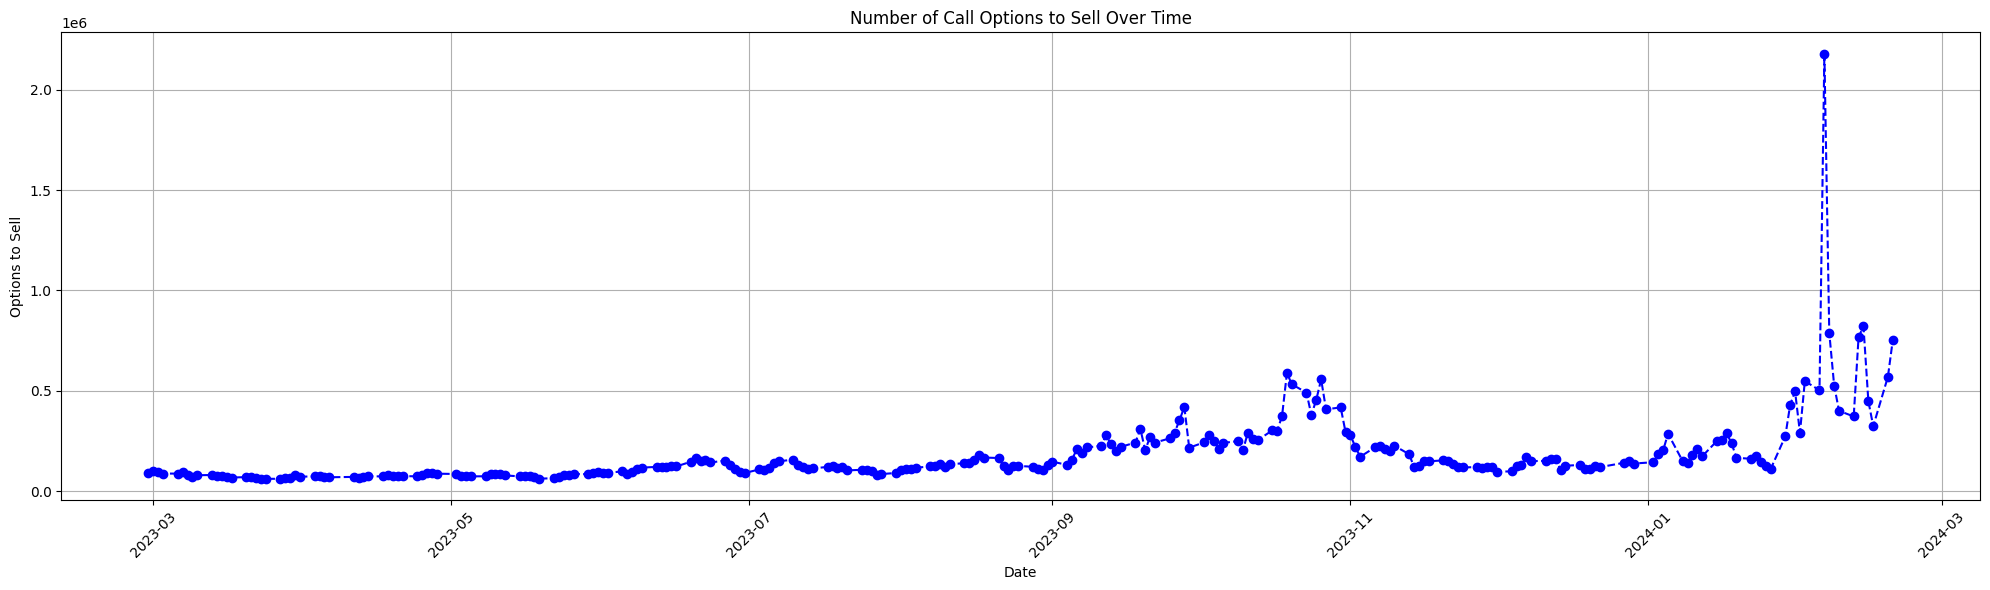

In [43]:

# Creating the plot
plt.figure(figsize=(20, 6))  # Set the figure size
plt.plot(bs_df_co.Date[:250], bs_df_co['Options_to_Sell'].iloc[:250], marker='o', linestyle='--', color='b')
plt.title('Number of Call Options to Sell Over Time')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Options to Sell')  # Y-axis label
plt.grid(True)  # Add gridlines
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust subplots to give some padding
plt.show()

In [44]:
np.random.seed(0)  # For reproducibility
jump_size_mean = 1.4  # Mean jump size
jump_size_std = 0.3  # Standard deviation of the jump size
bs_df_co['Price_Jump'] = np.random.normal(jump_size_mean, jump_size_std, bs_df_co.shape[0])

# Calculate new price after the jump
bs_df_co['New_Price'] = bs_df_co['Price'] + bs_df_co['Price_Jump']

# Calculate new delta per option assuming gamma remains constant
bs_df_co['New_Delta'] = bs_df_co['Original_Delta'] + bs_df_co['Original_Gamma'] * bs_df_co['Price_Jump']

In [45]:
# Calculate the original and new number of options sold to maintain delta neutrality
bs_df_co['Options_Sold_Originally'] = shares_long / bs_df_co['Original_Delta']
bs_df_co['Options_Sold_New'] = shares_long / bs_df_co['New_Delta']

# Calculate the additional options needed to sell to maintain delta neutrality
bs_df_co['Additional_Options_to_Sell'] = bs_df_co['Options_Sold_New'] - bs_df_co['Options_Sold_Originally']


### The additional options contracts to sell, given a sudden random jump in the price

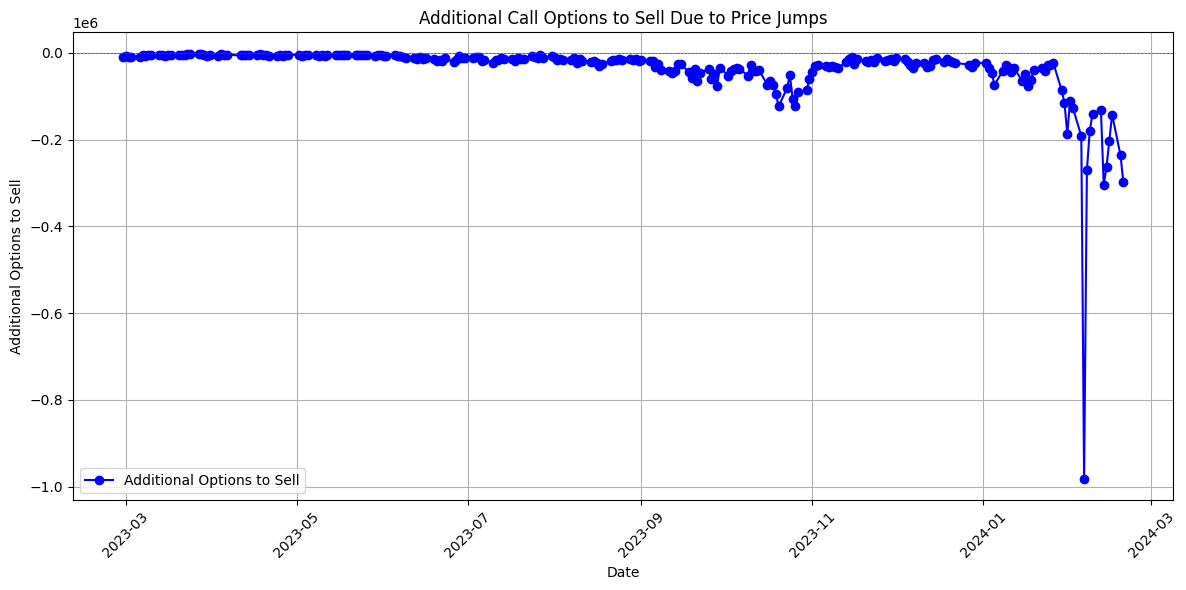

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(bs_df_co['Date'].iloc[:250], bs_df_co['Additional_Options_to_Sell'].iloc[:250], marker='o', linestyle='-', color='b', label='Additional Options to Sell')
plt.title('Additional Call Options to Sell Due to Price Jumps')
plt.xlabel('Date')
plt.ylabel('Additional Options to Sell')
plt.axhline(0, color='red', linewidth=0.5, linestyle='--')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust subplots to give some padding
plt.show()


We use a TotalEnergies call option with the same maturity with a gamma at time t of 0.4

In [56]:
shares_long = 25000  # Total shares you are long
hedging_option_gamma = 0.4

# Calculate total gamma exposure from the existing call options
bs_df_co['Total_Gamma_Existing_Options'] = bs_df_co['Original_Gamma'] * (shares_long / bs_df_co['Original_Delta'])

# Calculate the number of hedging options required to offset this gamma
bs_df_co['Hedging_Options_Required'] = bs_df_co['Total_Gamma_Existing_Options'] / hedging_option_gamma



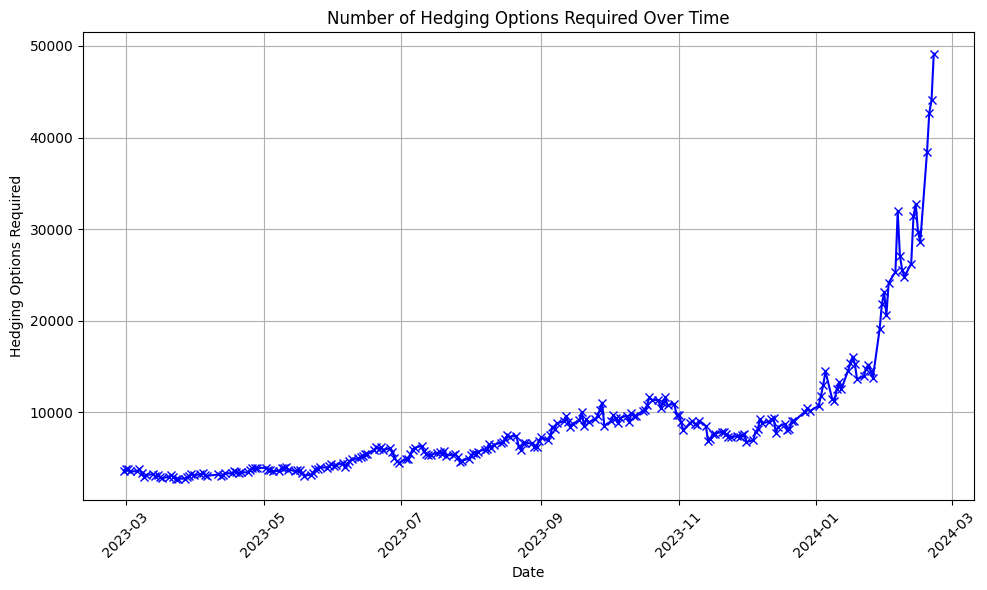

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(bs_df_co['Date'][:252], bs_df_co['Hedging_Options_Required'][:252], marker='x', linestyle='-', color='b')
plt.title('Number of Hedging Options Required Over Time')
plt.xlabel('Date')
plt.ylabel('Hedging Options Required')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Assuming that you have a portfolio position consisting of the call option from 3 b) and of the call option from 4 b), how can you adjust your portfolio to achieve a vega-neutral position? Make the necessary calculations and interpret the result."

In [61]:
# We will calculate the total vega for BS_CALL and MC_CALL for each date.
# Then, we will calculate the net vega for each date.
# Lastly, we will determine how many additional options need to be traded to hedge the vega for each date.

# Using the previously assumed values for MC_Call_Vega and additional_option_vega for the example
bs_df_co['Total_Vega_BS_CALL'] = bs_df_co['BS_CALL'] * bs_df_co['Original_Vega']
bs_df_co['Total_Vega_MC_CALL'] = bs_df_co['MC_CALL'] * bs_df_co['Original_Vega']

# Calculate the net vega for each date
bs_df_co['Net_Vega'] = bs_df_co['Total_Vega_BS_CALL'] + bs_df_co['Total_Vega_MC_CALL']

# Determine the number of options to hedge for each date to achieve a vega-neutral portfolio
# Assuming that we can trade options with a vega of -0.10 for hedging
additional_option_vega = -0.10
bs_df_co['Options_to_Hedge'] = -bs_df_co['Net_Vega'] / additional_option_vega

# Convert the number of options to hedge to the nearest integer since you can't trade fractional options
bs_df_co['Options_to_Hedge'] = bs_df_co['Options_to_Hedge'].apply(np.ceil)

# Let's look at the dataframe with the net vega and the options to hedge added
bs_df_co[['Net_Vega', 'Options_to_Hedge']]


,Net_Vega,Options_to_Hedge
0,1.971893e+00,20.0
1,1.639859e+00,17.0
2,1.693682e+00,17.0
3,2.060006e+00,21.0
4,2.095272e+00,21.0
...,...,...
253,3.104558e-08,1.0
254,5.492653e-11,1.0
255,9.164380e-25,1.0
256,0.000000e+00,0.0


## Price an american call and put with the same parameters using bionmal trees

In [68]:
import numpy as np

def binomial_tree_american(option_type, S, K, T, r, sigma, steps=100):
    dt = T / steps  # Length of time interval
    u = np.exp(sigma * np.sqrt(dt))  # Upward movement factor
    d = 1 / u  # Downward movement factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Initialize asset prices at maturity
    prices = np.array([S * u**j * d**(steps - j) for j in range(steps + 1)])

    # Initialize option values at maturity
    if option_type == 'call':
        values = np.maximum(prices - K, 0)
    else:  # put option
        values = np.maximum(K - prices, 0)

    # Recursive calculation of the option price
    for i in range(steps, 0, -1):
        values = (p * values[:-1] + (1 - p) * values[1:]) * np.exp(-r * dt)  # Discount back one time step
        prices = prices[:-1] * u  # All prices move down one level

        if option_type == 'call':
            exercise = np.maximum(prices - K, 0)  # Value of exercising call
        else:
            exercise = np.maximum(K - prices, 0)  # Value of exercising put

        values = np.maximum(values, exercise)  # American option condition

    return values[0]  # Value of the option at time 0

# Assuming the binomial_tree_american function is defined as provided in the previous step

# Apply the function to each row in the DataFrame to calculate option prices
bs_df_co['american_Option_Price'] = bs_df_co.apply(
    lambda row: binomial_tree_american(
       'call', row['Price'], 110, row['T'], row['STR'], row['Rolling_Volatility3M'], steps=253
    ), axis=1)

# Display the updated DataFrame with the calculated option prices


<ipython-input-68-a215a6a55374>:7: RuntimeWarning: invalid value encountered in scalar divide
  p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability


In [69]:
bs_df_co['american_put'] = bs_df_co.apply(
    lambda row: binomial_tree_american(
       'put', row['Price'], 110, row['T'], row['STR'], row['Rolling_Volatility3M'], steps=253
    ), axis=1)

<ipython-input-68-a215a6a55374>:7: RuntimeWarning: invalid value encountered in scalar divide
  p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability


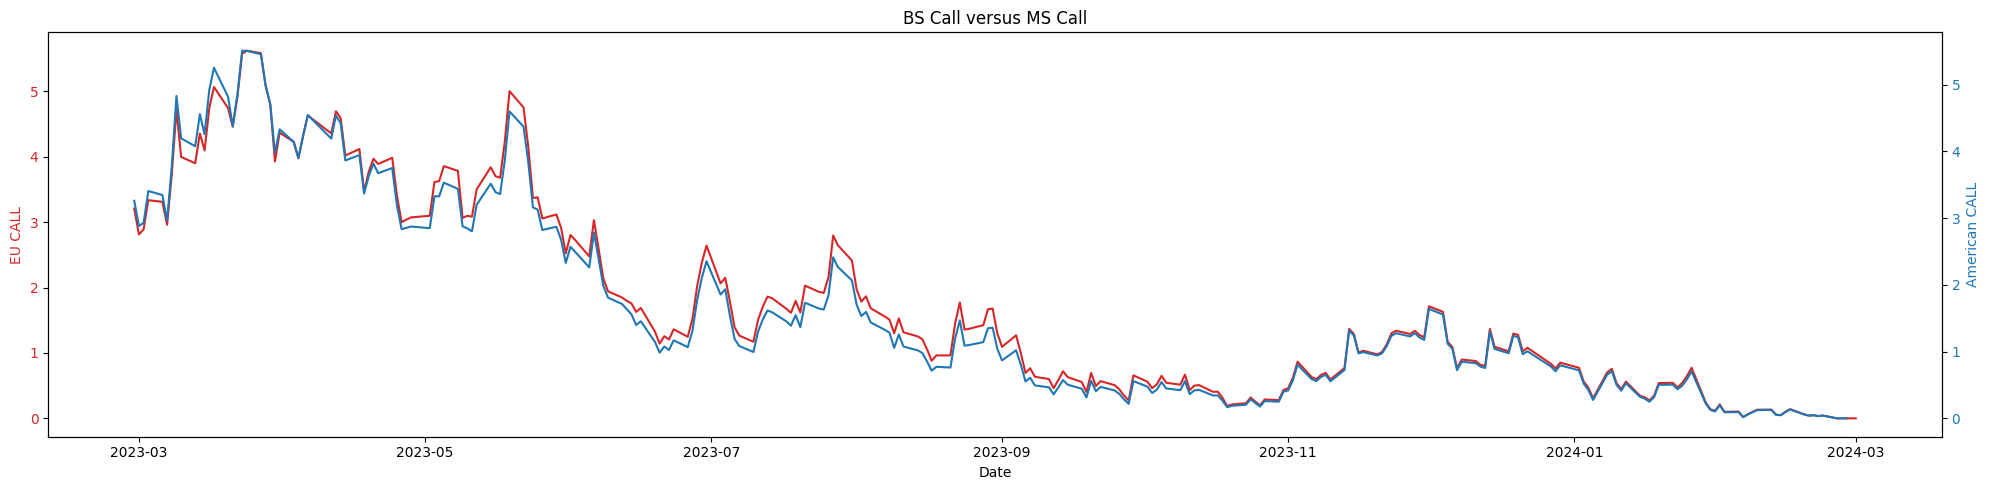

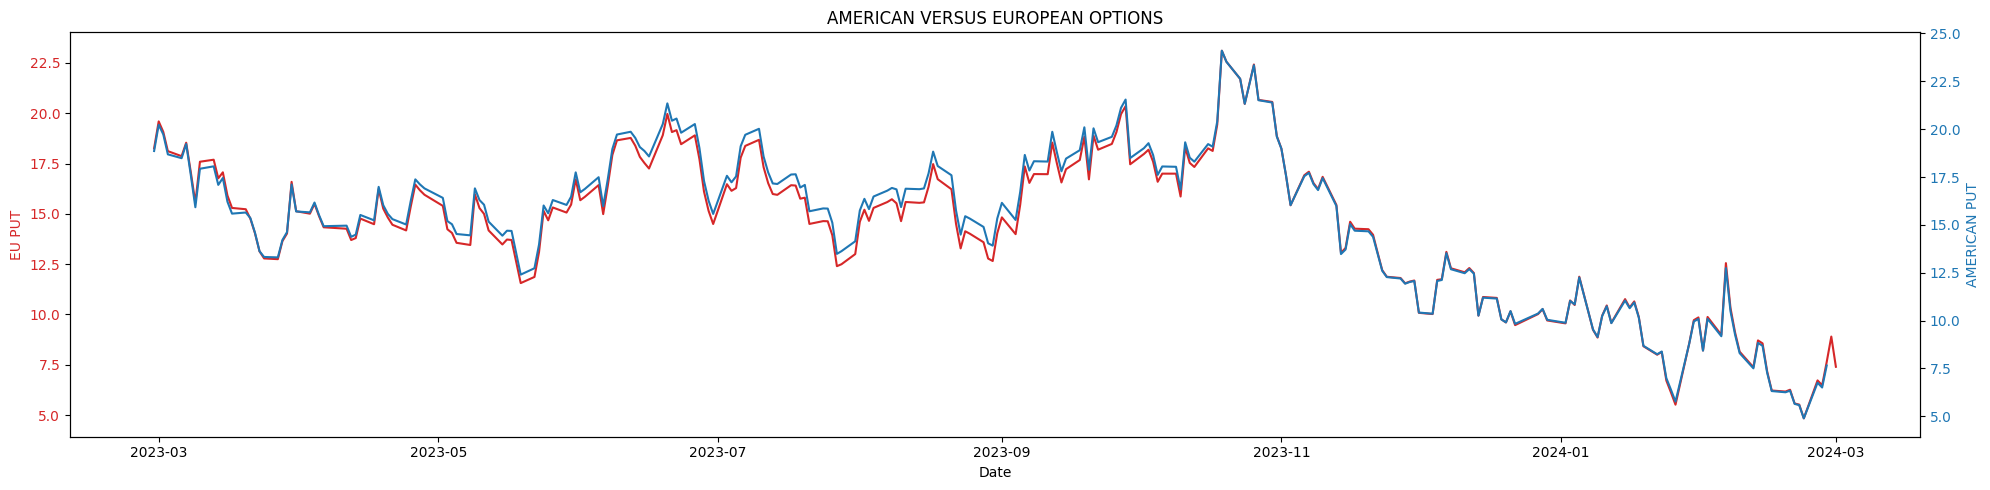

In [71]:
fig, ax1 = plt.subplots(figsize=(20, 5))
# Plotting 'Price' on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('EU CALL', color=color)
ax1.plot(bs_df_co.Date, bs_df_co['BS_CALL'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for the 'France' data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('American CALL', color=color)  # we already handled the x-label with ax1
ax2.plot(bs_df_co.Date, bs_df_co['american_Option_Price'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show
plt.title('BS Call versus MS Call')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

fig, ax1 = plt.subplots(figsize=(20, 5))
# Plotting 'Price' on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('EU PUT', color=color)
ax1.plot(bs_df_co.Date, bs_df_co['BS_PUT'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('AMERICAN PUT', color=color)  # we already handled the x-label with ax1
ax2.plot(bs_df_co.Date, bs_df_co['american_put'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show
plt.title('AMERICAN VERSUS EUROPEAN OPTIONS')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
